In [416]:
import pybinding as pb
import numpy as np
from numpy import sqrt as sqrt
import matplotlib.pyplot as plt
from numpy import exp, dot, einsum, cos, sin, pi
import sympy as sp
import cmath

In [455]:
a = 1 #lattice constant
# onsite energies
Ea = 0
Eb = 0
Ec = 0 

# lattice vectors
a1 = np.array([a, 0])
a2 = np.array([-a/2, a*sqrt(3)/2])
kagome_lattice = pb.Lattice(a1=a1, a2=a2)
disp = (a1+a2)/2
kagome_lattice.add_sublattices(
    ('A', np.array([0, 0])+disp, Ea), ('B', np.array([a/2, 0])+disp, Eb), ('C', np.array([-a/4, a*sqrt(3)/4])+disp, Ec))  # add an atom called 'A' at position [0, 0]

# nearest-neighbor hopping
t1 = 1
t2 = 0.5

kagome_lattice.add_hoppings(
    ([0, 0], 'A', 'B', t1+1j*t2),
    ([0, 0], 'A', 'C', t1-1j*t2),
    ([0, -1], 'A', 'C', t1-1j*t2),
    ([-1, 0], 'A', 'B', t1+1j*t2),
    ([1, 0], 'B', 'C', t1+1j*t2),
    ([0, -1], 'B', 'C', t1+1j*t2),
)

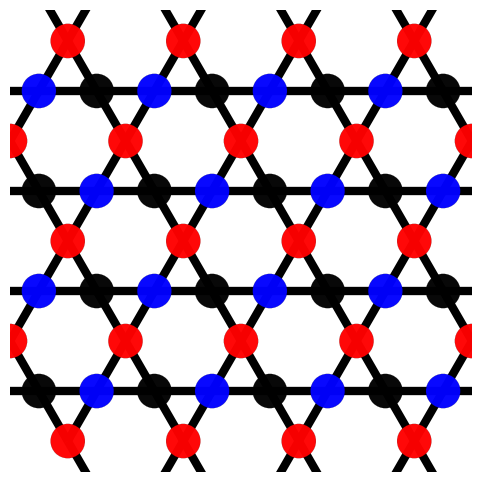

In [456]:
plt.figure(figsize=(6, 6))
kagome_model = pb.Model(
    kagome_lattice,
    pb.translational_symmetry()
)
kagome_model.plot(num_periods=6,
          hopping = {
  "width": 10, "color" : "black", "blend" : 1,
}, sites={"cmap":["black", "blue", "red"], "blend" : 1 })
plt.gca().axis('off');
plt.xlim(-2, 2)
plt.ylim(-2, 2);

In [443]:
def return_symeig(v, k, G1, G2):
    # We assume k is given in cartesian coordinates
    k1, k2 = np.einsum("ij, j->i", np.linalg.inv(np.array([G1, G2]).T), k)
    v1, v2, v3 = v
    return np.conj(v3)*v1*np.exp(1j*k1*2*pi) + np.conj(v1)*v2*np.exp(1j*(k1+k2)*2*pi) + np.conj(v2)*v3

In [444]:
solver = pb.solver.lapack(kagome_model)
G1, G2 = kagome_lattice.reciprocal_vectors()
G1 = G1[0:2]
G2 = G2[0:2]
Gamma = np.array([0, 0])
K = -2/3*G1+1/3*G2
Kprime = -K

In [445]:
topological_symeigs_allbands = dict()

for band_idx in range(0, 3):
    topological_symeigs = dict()
    for (klab, k) in zip(["Gamma", "K", "Kprime"], [Gamma, K, Kprime]):
        num_K1 = 0 
        num_K2 = 0
        num_K3 = 0 
        solver.set_wave_vector(k)
        symeig = return_symeig(solver.eigenvectors[:, band_idx], k, G1, G2)
        print("C3 symmetry eigenvalue at ", klab, " is ", np.round(symeig, 5))
        if np.isclose(cmath.phase(symeig)/pi, -2/3):
            num_K3 += 1
        if np.isclose(cmath.phase(symeig)/pi, 2/3):
            num_K2 += 1
        if np.isclose(cmath.phase(symeig)/pi, 0):
            num_K1 += 1
        topological_symeigs[klab] = [num_K1, num_K2, num_K3]
    topological_symeigs_allbands[band_idx] = topological_symeigs


C3 symmetry eigenvalue at  Gamma  is  (-0.5+0.86603j)
C3 symmetry eigenvalue at  K  is  (1+0j)
C3 symmetry eigenvalue at  Kprime  is  (1+0j)
C3 symmetry eigenvalue at  Gamma  is  (-0.5-0.86603j)
C3 symmetry eigenvalue at  K  is  (-0.5-0.86603j)
C3 symmetry eigenvalue at  Kprime  is  (-0.5-0.86603j)
C3 symmetry eigenvalue at  Gamma  is  (1+0j)
C3 symmetry eigenvalue at  K  is  (-0.5+0.86603j)
C3 symmetry eigenvalue at  Kprime  is  (-0.5+0.86603j)


In [446]:
def return_chern_number(symeigs_dict):
    Gamma1, Gamma2, Gamma3 = symeigs_dict["Gamma"]
    K1, K2, K3 = symeigs_dict["K"]
    Kprime1, Kprime2, Kprime3 = symeigs_dict["Kprime"]
    return np.mod(-(K1-Gamma1) -2*(K2-Gamma2)+2*(Kprime1-Gamma1)+(Kprime2-Gamma2), 3)

In [447]:
for band_idx in range(0, 3):
    topological_symeigs = topological_symeigs_allbands[band_idx]
    chern_number = return_chern_number(topological_symeigs)
    print(f"Chern number for band {band_idx}: {chern_number} (mod 3)")

Chern number for band 0: 2 (mod 3)
Chern number for band 1: 0 (mod 3)
Chern number for band 2: 1 (mod 3)


# Creating the lattice with a different set of basis vectors

In [460]:
a = 1 #lattice constant
# onsite energies
Ea = 0
Eb = 0
Ec = 0 

# lattice vectors
a1 = np.array([a, 0])
a2 = np.array([-a/2, a*sqrt(3)/2])
kagome_lattice = pb.Lattice(a1=a1, a2=a2)
disp = (a1+a2)/2
kagome_lattice.add_sublattices(
    ('A', np.array([0, 0])+disp, Ea), ('B', np.array([-a/2, 0])+disp, Eb), ('C', np.array([-a/4, a*sqrt(3)/4])+disp, Ec))  # add an atom called 'A' at position [0, 0]

# nearest-neighbor hopping
t1 = 1
t2 = 0.5

kagome_lattice.add_hoppings(
    ([0, 0], 'A', 'B', t1+1j*t2),
    ([0, 0], 'A', 'C', t1-1j*t2),
    ([0, 0], 'B', 'C', t1+1j*t2),
    
    ([-1, -1], 'B', 'C', t1+1j*t2),
    ([0, -1], 'A', 'C', t1-1j*t2),
    ([1, 0], 'A', 'B', t1+1j*t2),
)
kagome_model = pb.Model(
    kagome_lattice,
    pb.translational_symmetry()
)

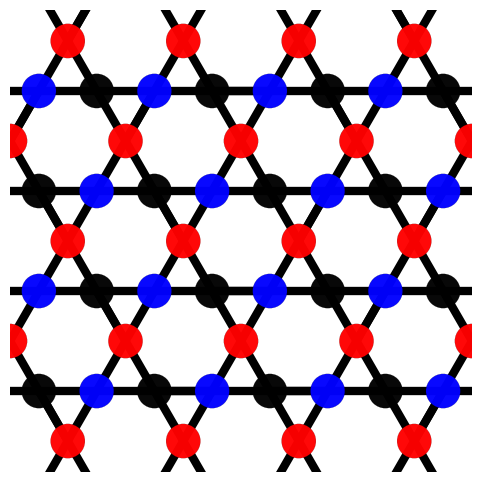

In [449]:
plt.figure(figsize=(6, 6))
kagome_model.plot(num_periods=6,
          hopping = {
  "width": 10, "color" : "black", "blend" : 1,
}, sites={"cmap":["black", "blue", "red"], "blend" : 1 })
plt.gca().axis('off');
plt.xlim(-2, 2)
plt.ylim(-2, 2);

In [461]:
def return_symeig(v, k, G1, G2):
    # We assume k is given in cartesian coordinates
    k1, k2 = np.einsum("ij, j->i", np.linalg.inv(np.array([G1, G2]).T), k)
    v1, v2, v3 = v
    return np.conj(v3)*v1 + np.conj(v1)*v2 + np.conj(v2)*v3

In [462]:
solver = pb.solver.lapack(kagome_model)
G1, G2 = kagome_lattice.reciprocal_vectors()
G1 = G1[0:2]
G2 = G2[0:2]
Gamma = np.array([0, 0])
K = -2/3*G1+1/3*G2
Kprime = -K

In [463]:
topological_symeigs_allbands = dict()

for band_idx in range(0, 3):
    topological_symeigs = dict()
    for (klab, k) in zip(["Gamma", "K", "Kprime"], [Gamma, K, Kprime]):
        num_K1 = 0 
        num_K2 = 0
        num_K3 = 0 
        solver.set_wave_vector(k)
        symeig = return_symeig(solver.eigenvectors[:, band_idx], k, G1, G2)
        print("C3 symmetry eigenvalue at ", klab, " is ", np.round(symeig, 5))
        if np.isclose(cmath.phase(symeig)/pi, -2/3):
            num_K3 += 1
        if np.isclose(cmath.phase(symeig)/pi, 2/3):
            num_K2 += 1
        if np.isclose(cmath.phase(symeig)/pi, 0):
            num_K1 += 1
        topological_symeigs[klab] = [num_K1, num_K2, num_K3]
    topological_symeigs_allbands[band_idx] = topological_symeigs


C3 symmetry eigenvalue at  Gamma  is  (-0.5+0.86603j)
C3 symmetry eigenvalue at  K  is  (-0.5-0.86603j)
C3 symmetry eigenvalue at  Kprime  is  (-0.5+0.86603j)
C3 symmetry eigenvalue at  Gamma  is  (-0.5-0.86603j)
C3 symmetry eigenvalue at  K  is  (-0.5+0.86603j)
C3 symmetry eigenvalue at  Kprime  is  (1+0j)
C3 symmetry eigenvalue at  Gamma  is  (1+0j)
C3 symmetry eigenvalue at  K  is  (1+0j)
C3 symmetry eigenvalue at  Kprime  is  (-0.5-0.86603j)


In [470]:
def return_chern_number(symeigs_dict):
    Gamma1, Gamma2, Gamma3 = symeigs_dict["Gamma"]
    K1, K2, K3 = symeigs_dict["K"]
    Kprime1, Kprime2, Kprime3 = symeigs_dict["Kprime"]
    return np.mod(-(K1-Gamma1) -2*(K2-Gamma2)+2*(Kprime1-Gamma1)+(Kprime2-Gamma2), 3)
    #return np.mod(-(K1-Gamma1) -2*(K2-Gamma2)+2*(Kprime1-Gamma1)+(Kprime2-Gamma2), 3)

In [471]:
for band_idx in range(0, 3):
    topological_symeigs = topological_symeigs_allbands[band_idx]
    chern_number = return_chern_number(topological_symeigs)
    print(f"Chern number for band {band_idx}: {chern_number} (mod 3)")

Chern number for band 0: 2 (mod 3)
Chern number for band 1: 0 (mod 3)
Chern number for band 2: 1 (mod 3)
